<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/04_gaussian_mixtures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Gaussian Mixtures

A Gaussian mixture model (GMM) is a probabilistic model that assumes that the
instances were generated from a mixture of several Gaussian distributions whose parameters are unknown. All the instances generated from a single Gaussian distribution form a cluster that typically looks like an ellipsoid.

When you observe an instance, you know it was generated from one of the Gaussian distributions, but you are not told which one, and you do not know what the parameters of these distributions are.

There are several GMM variants. In the simplest variant, implemented in the `GaussianMixture` class, you must know in advance the number $k$ of Gaussian distributions.

This generative process can be represented as a graphical model.

<img src='https://github.com/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/9-unsupervised-learning-techniques/images/1.png?raw=1' width='600'/>

So, what can you do with such a model?

Well, given the dataset $X$, you typically want
to start by estimating the weights ϕ and all the distribution parameters $\mu(1)$ to $\mu(k)$ and
Σ(1) to Σ(k). 

Scikit-Learn’s GaussianMixture class makes this super easy.





##Setup

In [ ]:
# Common imports
import numpy as np
import os
from timeit import timeit

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.model_selection import train_test_split

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs
from sklearn.datasets import load_digits
from sklearn.datasets import make_moons

from scipy.stats import norm

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.colors import LogNorm
from matplotlib.patches import Polygon

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Let's define some ploting methods.

In [ ]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [ ]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

##Gaussian mixture model

Let’s take a look at DBSCAN,
another popular clustering algorithm that illustrates a very different approach based
on local density estimation. This approach allows the algorithm to identify clusters of
arbitrary shapes.

This algorithm defines clusters as continuous regions of high density. 

This algorithm works well if all the clusters are dense enough and if they are well separated
by low-density regions.

The DBSCAN class in Scikit-Learn is as simple to use as
you might expect. 

Let’s test it on the moons dataset.

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

In [ ]:
dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X, y)

DBSCAN(eps=0.05)

The labels of all the instances are now available in the labels_ instance variable:

In [ ]:
dbscan.labels_[:20]

array([ 0,  2, -1, -1,  1,  0,  0,  0,  2,  5,  2,  3,  0,  2,  2,  2,  4,
        2,  2,  4])

Notice that some instances have a cluster index equal to –1, which means that they
are considered as anomalies by the algorithm. 

The indices of the core instances are
available in the `core_sample_indices_` instance variable, and the core instances
themselves are available in the `components_` instance variable:

In [ ]:
len(dbscan.core_sample_indices_)

808

In [ ]:
dbscan.core_sample_indices_[:20]

array([ 0,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21,
       22, 23, 24])

In [ ]:
dbscan.components_[:5]

array([[-0.02137124,  0.40618608],
       [-0.84192557,  0.53058695],
       [ 0.58930337, -0.32137599],
       [ 0.29248724, -0.20696309],
       [-0.02637836,  0.44766267]])

In [ ]:
np.unique(dbscan.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6])

In [ ]:
dbscan2 = DBSCAN(eps=0.2)
dbscan2.fit(X)

DBSCAN(eps=0.2)

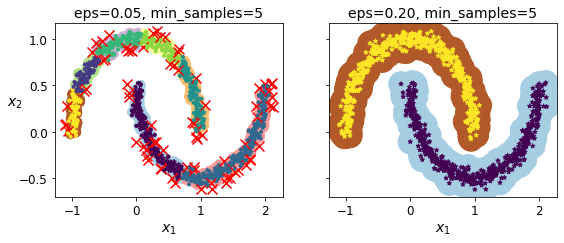

In [ ]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)

plt.show()

As you can see, it
identified quite a lot of anomalies, plus seven different clusters. How disappointing!

Fortunately, if we widen each instance’s neighborhood by increasing eps to 0.2, we get
the clustering on the right, which looks perfect. 

Let’s continue with this model.



In [ ]:
dbscan = dbscan2

Somewhat surprisingly, the DBSCAN class does not have a `predict()` method, although it has a `fit_predict()` method. In other words, it cannot predict which cluster a new instance belongs to.

This implementation decision was made because different classification
algorithms can be better for different tasks, so the authors decided to let the user choose which one to use.Moreover, it’s not hard to implement. 

For example, let’s
train a KNeighborsClassifier:

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(dbscan.components_, dbscan.labels_[dbscan.core_sample_indices_])

KNeighborsClassifier(n_neighbors=50)

Now, given a few new instances, we can predict which cluster they most likely belong
to and even estimate a probability for each cluster:

In [ ]:
x_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
knn.predict(x_new)

array([1, 0, 1, 0])

In [ ]:
knn.predict_proba(x_new)

array([[0.18, 0.82],
       [1.  , 0.  ],
       [0.12, 0.88],
       [1.  , 0.  ]])

Note that we only trained the classifier on the core instances, but we could also have
chosen to train it on all the instances, or all but the anomalies: this choice depends on
the final task.

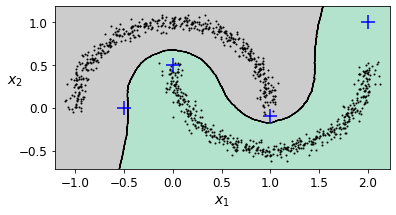

In [ ]:
plt.figure(figsize=(6, 3))
plot_decision_boundaries(knn, X, show_centroids=False)
plt.scatter(x_new[:, 0], x_new[:, 1], c="b", marker="+", s=200, zorder=10)

plt.show()

Notice that since there is no anomaly in the training set, the classifier
always chooses a cluster, even when that cluster is far away. It is fairly straightforward
to introduce a maximum distance, in which case the two instances that are
far away from both clusters are classified as anomalies.


To do this, use the `kneighbors()` method of the `KNeighborsClassifier`. Given a set of instances, it returns the distances and the indices of the k nearest neighbors in the training set (two matrices,
each with k columns):

In [ ]:
y_dist, y_pred_idx = knn.kneighbors(x_new, n_neighbors=1)

y_pred = dbscan.labels_[dbscan.core_sample_indices_][y_pred_idx]
y_pred[y_dist > 0.2] == -1
y_pred.ravel()

array([1, 0, 1, 0])

In short, `DBSCAN` is a very simple yet powerful algorithm capable of identifying any
number of clusters of any shape. It is robust to outliers, and it has just two hyperparameters
(eps and `min_samples`).

If the density varies significantly across the clusters,
however, it can be impossible for it to capture all the clusters properly. Its computational
complexity is roughly `O(m log m)`, making it pretty close to linear with regard
to the number of instances, but Scikit-Learn’s implementation can require up to
`O(m2)` memory if eps is large.

##Others Clustering Algorithms

Scikit-Learn implements several more clustering algorithms that you should take a look at.